In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from torch.utils.data import DataLoader, Dataset, random_split
import seaborn as sns
from torchvision import transforms
import glob
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from itertools import cycle

In [31]:
# Global Parameters
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [32]:
# Hyperparameters
EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Model saving
SAVE_MODEL = True
MODEL_SAVE_PATH = '../models/lens_cnn_multi.pth'

# Dataset paths - updated for multi-class
TRAIN_PATH = '../dataset/train/'
VAL_PATH = '../dataset/val/'

# Class mapping
CLASS_MAPPING = {
    'no': 0,      # No substructure
    'sphere': 1,  # Subhalo substructure
    'vort': 2     # Vortex substructure
}

In [33]:
# Visualize Sample Images
def visualize_sample_images(base_dir, num_samples=3):
    """Plot sample images from all three classes"""
    class_dirs = ['no', 'sphere', 'vort']
    class_names = ['No Substructure', 'Subhalo Substructure', 'Vortex Substructure']
    
    fig, axes = plt.subplots(len(class_dirs), num_samples, figsize=(15, 12))
    
    for class_idx, class_dir in enumerate(class_dirs):
        files = os.listdir(os.path.join(base_dir, class_dir))[:num_samples]
        
        for i, file_name in enumerate(files):
            file_path = os.path.join(base_dir, class_dir, file_name)
            
            # Handle different file types (assuming image files)
            if file_name.endswith('.npy'):
                img = np.load(file_path)
                if img.shape[0] == 3:  # If shape is (3, H, W)
                    img = np.transpose(img, (1, 2, 0))  # Convert to (H, W, 3)
                elif img.shape[0] == 1:  # If shape is (1, H, W)
                    img = np.squeeze(img, axis=0)  # Convert to (H, W)
            else:  # For regular image files
                from PIL import Image
                img = np.array(Image.open(file_path))
            
            # Normalize for display
            if img.ndim == 3:  # Color image
                img = (img - img.min()) / (img.max() - img.min() + 1e-8)
            
            axes[class_idx, i].imshow(img)
            axes[class_idx, i].set_title(f"{class_names[class_idx]}: {file_name}")
            axes[class_idx, i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/sample_images_multi.png')
    plt.show()


In [34]:
# Custom Dataset for multi-class classification
class LensMultiClassDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = base_dir
        self.transform = transform
        self.class_dirs = ['no', 'sphere', 'vort']
        
        self.files = []
        self.labels = []
        
        # Collect all files and labels
        for class_name in self.class_dirs:
            class_path = os.path.join(base_dir, class_name)
            class_files = glob.glob(os.path.join(class_path, '*'))
            
            self.files.extend(class_files)
            self.labels.extend([CLASS_MAPPING[class_name]] * len(class_files))
        
        # Print class distribution
        print(f"Dataset '{base_dir}' distribution:")
        for class_name in self.class_dirs:
            count = self.labels.count(CLASS_MAPPING[class_name])
            print(f"  - {class_name}: {count} samples")
        
    def __len__(self):
        return len(self.files)
        
    def __getitem__(self, idx):
        file_path = self.files[idx]
        
        # Handle different file types
        if file_path.endswith('.npy'):
            data = np.load(file_path)
            
            # Check data shape and ensure it's (3, H, W)
            if data.ndim == 2:  # If grayscale (H, W)
                data = np.stack([data, data, data])  # Create 3 identical channels
            elif data.ndim == 3:
                if data.shape[0] == 1:  # If (1, H, W)
                    data = np.repeat(data, 3, axis=0)  # Repeat to make 3 channels
                elif data.shape[2] == 3 or data.shape[2] == 1:  # If (H, W, C)
                    data = np.transpose(data, (2, 0, 1))  # Convert to (C, H, W)
                    if data.shape[0] == 1:  # If only 1 channel after transpose
                        data = np.repeat(data, 3, axis=0)  # Make 3 channels
        else:
            # For regular image files
            from PIL import Image
            img = Image.open(file_path).convert('RGB')  # Force RGB
            
            if self.transform:
                img = self.transform(img)
                return img, self.labels[idx]
            
            # Convert to numpy array with correct shape
            data = np.array(img)
            data = np.transpose(data, (2, 0, 1))  # Convert to (C, H, W)
        
        # Ensure == 3 channels
        if data.shape[0] != 3:
            print(f"Warning: {file_path} has {data.shape[0]} channels, forcing to 3")
            if data.shape[0] == 1:
                data = np.repeat(data, 3, axis=0)
            else:
                data = data[:3]  # Take first 3 channels if more
        
        # Normalize the data
        data = (data - np.mean(data)) / (np.std(data) + 1e-8)
        
        # Convert to tensor
        tensor_data = torch.tensor(data, dtype=torch.float32)
        
        return tensor_data, self.labels[idx]
        

In [35]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = LensMultiClassDataset(TRAIN_PATH, transform)
val_dataset = LensMultiClassDataset(VAL_PATH, transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")



Dataset '../dataset/train/' distribution:
  - no: 10000 samples
  - sphere: 10000 samples
  - vort: 10000 samples
Dataset '../dataset/val/' distribution:
  - no: 2500 samples
  - sphere: 2500 samples
  - vort: 2500 samples
Training samples: 30000
Validation samples: 7500


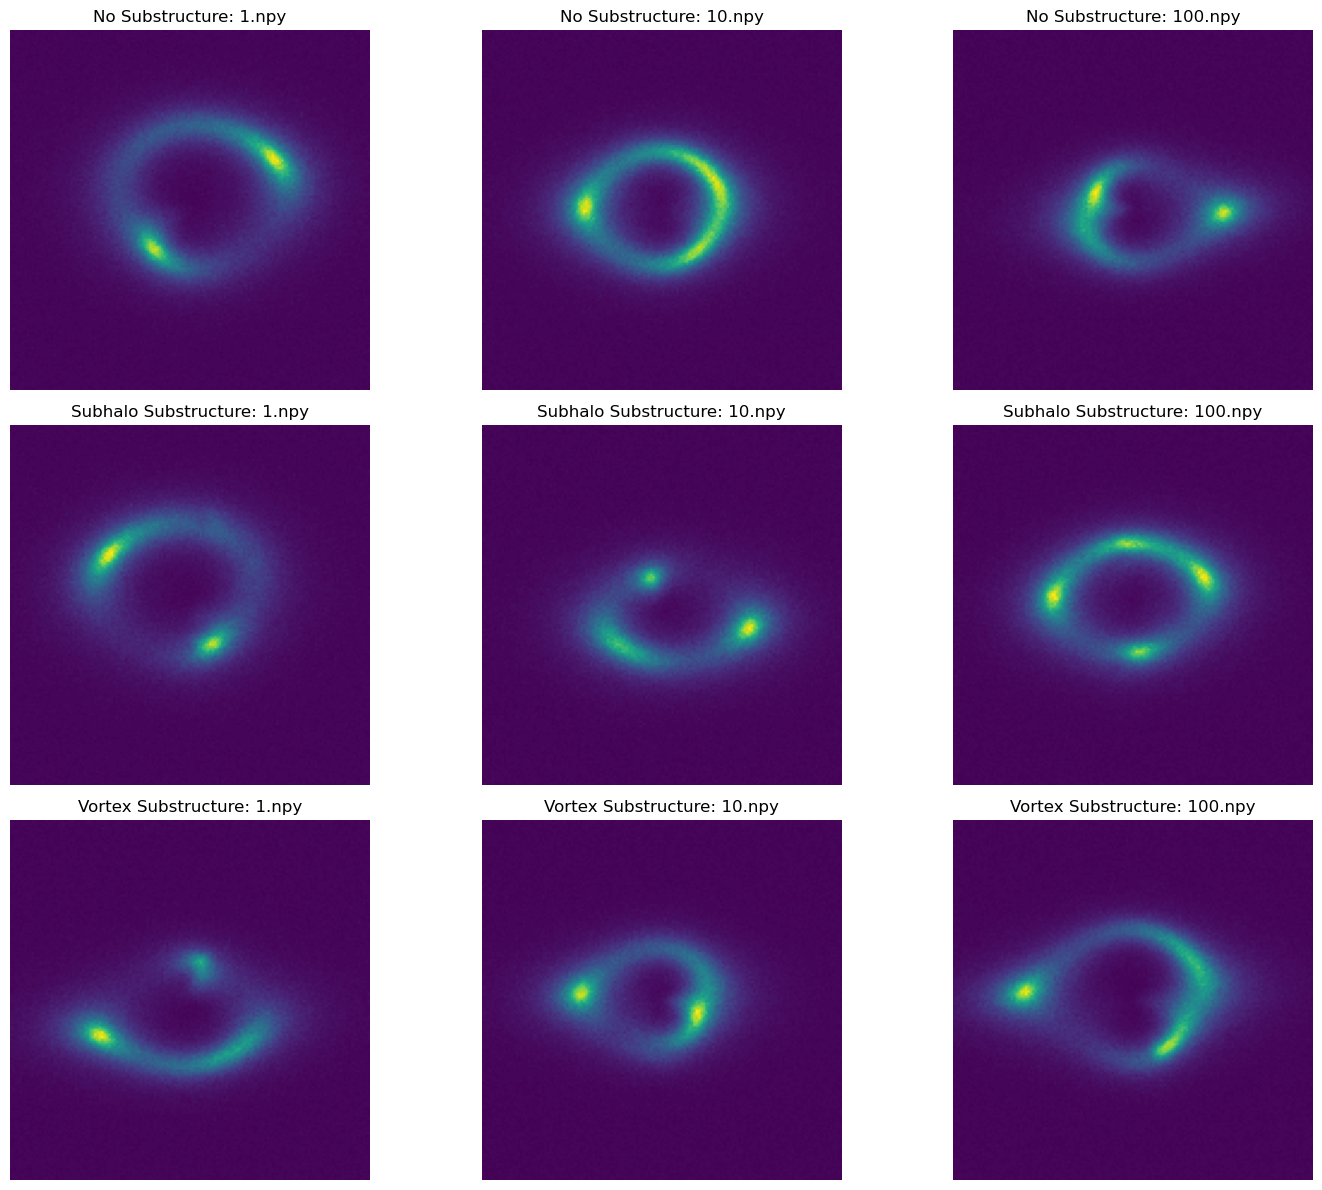

In [36]:
# Visualize training samples
visualize_sample_images(TRAIN_PATH)


In [45]:
# Model Architecture - Updated for 3 classes
class LensMultiClassCNN(nn.Module):
    def __init__(self, num_classes=3, dropout_rate=0.5):
        super(LensMultiClassCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout2d(dropout_rate)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        
        # Fourth convolutional block for more complex features
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout2d(dropout_rate)
        
        # Calculate the size after convolutions
        # Assuming input is 64x64, after 4 pooling layers: 4x4
        self.fc1 = nn.Linear(256 * 9 * 9, 512)
        self.dropout5 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Fourth block
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        # Flatten and fully connected layers
        x = x.view(x.size(0), -1)  # Dynamic flattening
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout5(x)
        x = self.fc2(x)
        
        return x

In [46]:
# Initialize Model and Optimizer
num_classes = len(CLASS_MAPPING)

# Calculate class weights to handle imbalance
class_counts = [train_dataset.labels.count(i) for i in range(num_classes)]
total = sum(class_counts)
class_weights = torch.tensor([total / (num_classes * count) for count in class_counts], dtype=torch.float32)
class_weights = class_weights.to(device)

model = LensMultiClassCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [47]:
# Training Function
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc

In [48]:
# Validation Function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / len(val_loader)
    val_acc = 100 * correct / total
    
    return val_loss, val_acc

In [49]:
# Training Loop
def train_model():
    # For tracking metrics
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_val_loss = float('inf')
    
    for epoch in range(EPOCHS):
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Print stats
        print(f"Epoch [{epoch+1}/{EPOCHS}] | "
              f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        
        # Save best model
        if val_loss < best_val_loss and SAVE_MODEL:
            best_val_loss = val_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)
            print(f"Model saved at epoch {epoch+1}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('../results/training_history_multi.png')
    plt.show()
    
    return train_losses, train_accuracies, val_losses, val_accuracies


In [50]:
# Evaluation Functions for multi-class classification
def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())  # All class probabilities
    
    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)
    
    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, 
                               target_names=['No Substructure', 'Subhalo', 'Vortex']))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['No Substructure', 'Subhalo', 'Vortex'],
               yticklabels=['No Substructure', 'Subhalo', 'Vortex'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('../results/confusion_matrix_multi.png')
    plt.show()
    
    # Multi-class ROC curve and AUC
    n_classes = len(CLASS_MAPPING)
    
    # Binarize the labels for ROC curve calculation
    y_bin = label_binarize(all_labels, classes=list(range(n_classes)))
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    
    colors = cycle(['blue', 'red', 'green'])
    class_names = ['No Substructure', 'Subhalo', 'Vortex']
    
    for i, color, name in zip(range(n_classes), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{name} (AUC = {roc_auc[i]:.3f})')
    
    # Plot diagonal
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve')
    plt.legend(loc='lower right')
    plt.savefig('../results/roc_curve_multi.png')
    plt.show()
    
    # Calculate weighted average AUC
    weights = np.bincount(all_labels) / len(all_labels)
    weighted_auc = sum(weights[i] * roc_auc[i] for i in range(n_classes))
    
    return weighted_auc, roc_auc

In [51]:
# Visualize Sample Predictions
def visualize_predictions(model, test_loader, num_samples=5):
    model.eval()
    
    # Get some test samples
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    
    # Make predictions
    images = images[:num_samples].to(device)
    labels = labels[:num_samples].cpu().numpy()
    
    with torch.no_grad():
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    # Convert to numpy for visualization
    images = images.cpu().numpy()
    predicted = predicted.cpu().numpy()
    probs = probs.cpu().numpy()
    
    # Class names
    class_names = ['No Substructure', 'Subhalo', 'Vortex']
    
    # Plot images with predictions
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    
    for i in range(num_samples):
        # Display the RGB image
        img = np.transpose(images[i], (1, 2, 0))
        
        # Normalize to [0, 1] for display
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        axes[i].imshow(img)
        axes[i].set_title(f"True: {class_names[labels[i]]}\n"
                         f"Pred: {class_names[predicted[i]]}\n"
                         f"Prob: {probs[i][predicted[i]]:.2f}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/sample_predictions_multi.png')
    plt.show()

Epoch [1/25] | Train Loss: 1.1629 | Train Acc: 33.51% | Val Loss: 1.0987 | Val Acc: 33.33%
Model saved at epoch 1
Epoch [2/25] | Train Loss: 1.0994 | Train Acc: 33.35% | Val Loss: 1.0986 | Val Acc: 33.33%
Model saved at epoch 2
Epoch [3/25] | Train Loss: 1.0999 | Train Acc: 32.94% | Val Loss: 1.0986 | Val Acc: 33.33%
Model saved at epoch 3
Epoch [4/25] | Train Loss: 1.0995 | Train Acc: 33.12% | Val Loss: 1.0987 | Val Acc: 33.33%
Epoch [5/25] | Train Loss: 1.1005 | Train Acc: 32.90% | Val Loss: 1.0987 | Val Acc: 33.33%
Epoch [6/25] | Train Loss: 1.0993 | Train Acc: 33.25% | Val Loss: 1.0986 | Val Acc: 33.33%
Epoch [7/25] | Train Loss: 1.0994 | Train Acc: 33.33% | Val Loss: 1.0987 | Val Acc: 33.37%
Epoch [8/25] | Train Loss: 1.1000 | Train Acc: 33.21% | Val Loss: 1.0986 | Val Acc: 33.33%
Epoch [9/25] | Train Loss: 1.1003 | Train Acc: 33.40% | Val Loss: 1.0986 | Val Acc: 33.40%
Model saved at epoch 9
Epoch [10/25] | Train Loss: 1.0993 | Train Acc: 33.12% | Val Loss: 1.0986 | Val Acc: 33.3

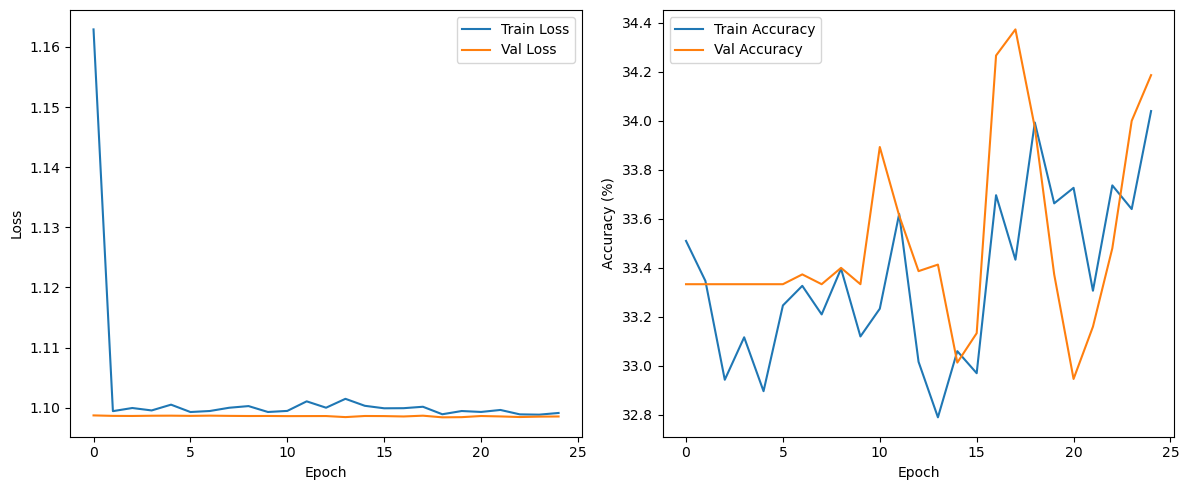

In [52]:
# Run Training
history = train_model()

Loaded best model for evaluation
Classification Report:
                 precision    recall  f1-score   support

No Substructure       0.37      0.05      0.08      2500
        Subhalo       0.34      0.33      0.33      2500
         Vortex       0.34      0.64      0.44      2500

       accuracy                           0.34      7500
      macro avg       0.35      0.34      0.29      7500
   weighted avg       0.35      0.34      0.29      7500



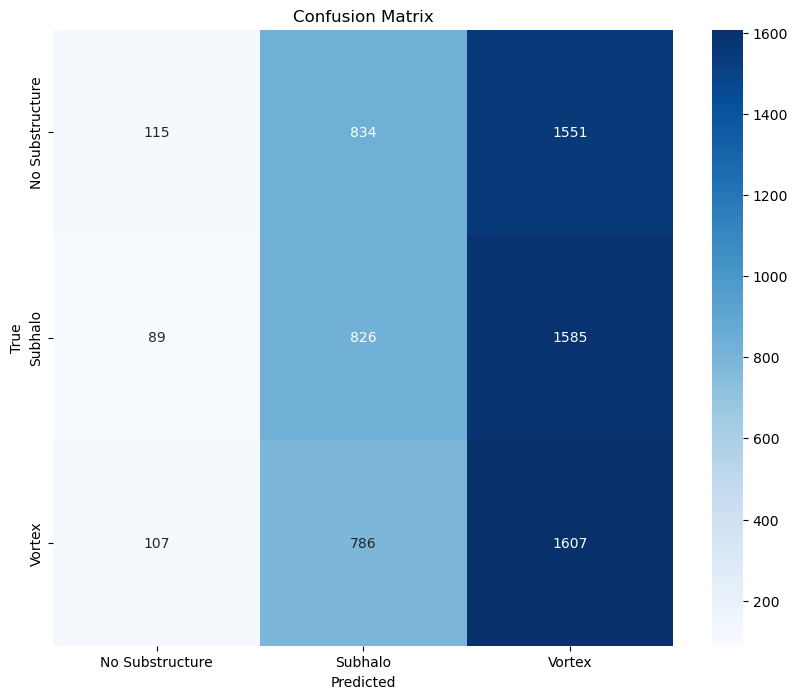

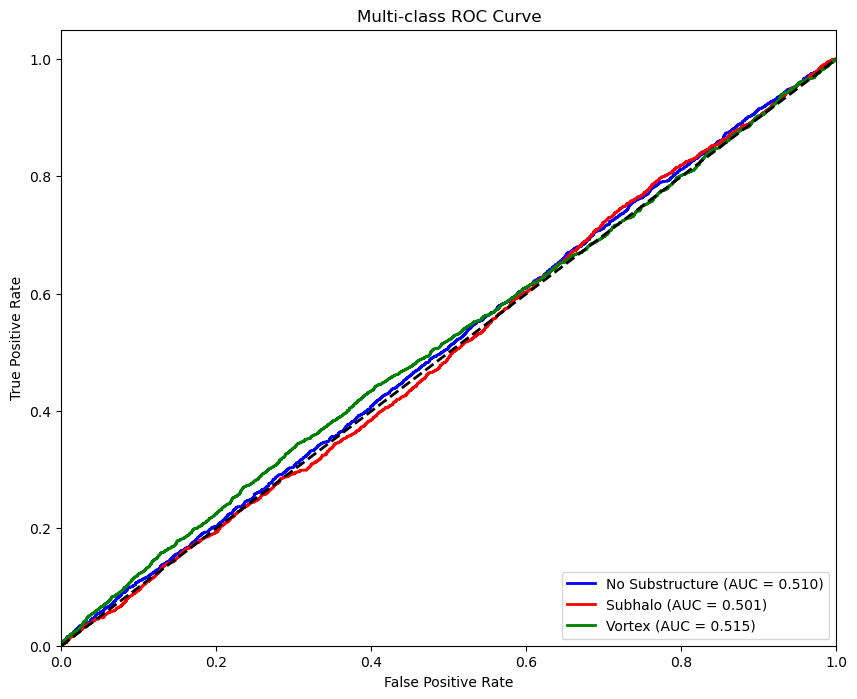

Weighted AUC Score: 0.5086
Class AUC Scores: No Substructure: 0.5095, Subhalo: 0.5011, Vortex: 0.5152


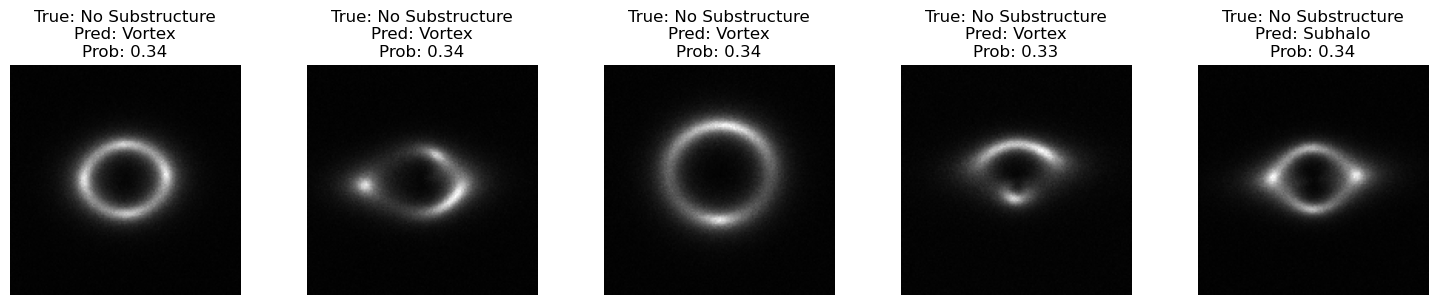

In [53]:
 # Load best model if available
if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print("Loaded best model for evaluation")

# Evaluate model
weighted_auc, class_aucs = evaluate_model(model, val_loader)
print(f"Weighted AUC Score: {weighted_auc:.4f}")
print(f"Class AUC Scores: No Substructure: {class_aucs[0]:.4f}, Subhalo: {class_aucs[1]:.4f}, Vortex: {class_aucs[2]:.4f}")

# Visualize sample predictions
visualize_predictions(model, val_loader)


In [54]:
# Feature Visualization
def visualize_filters(model, layer_num=0, num_filters=8):
    """Visualize filters from a convolutional layer"""
    
    # Get the conv layers
    conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]
    
    if layer_num >= len(conv_layers):
        print(f"Layer number {layer_num} is out of range. Max is {len(conv_layers)-1}")
        return
    
    # Get the weights
    weights = conv_layers[layer_num].weight.data.cpu().numpy()
    
    # Plot the first num_filters filters
    num_to_plot = min(num_filters, weights.shape[0])
    
    fig, axes = plt.subplots(1, num_to_plot, figsize=(15, 3))
    
    for i in range(num_to_plot):
        # For the first layer, RGB channels
        if layer_num == 0:
            # Shape is (out_channels, in_channels, height, width)
            # Take the mean across input channels for visualization
            img = np.mean(weights[i], axis=0)
        else:
            # For deeper layers, take the first input channel
            img = weights[i, 0]
        
        # Normalize for display
        img = (img - img.min()) / (img.max() - img.min() + 1e-8)
        
        axes[i].imshow(img, cmap='viridis')
        axes[i].set_title(f"Filter {i+1}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'../results/filters_layer{layer_num}.png')
    plt.show()

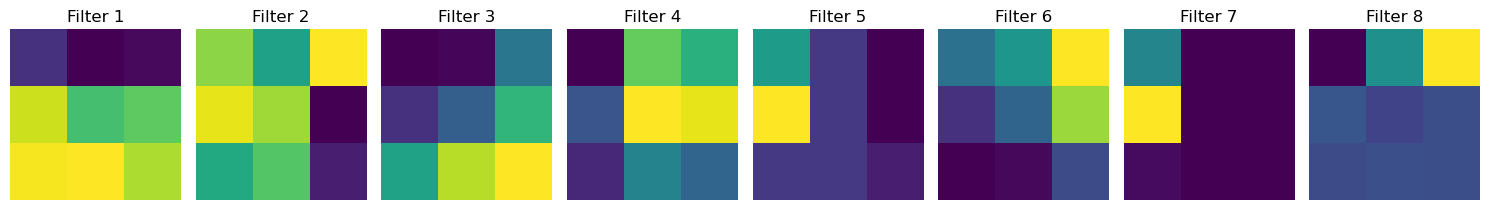

In [55]:
# Visualize filters from the first convolutional layer
visualize_filters(model, layer_num=0)